In [16]:
import sqlite3
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt

In [17]:
def _(cur, sql):
    cur.execute(sql)
    return cur.fetchall()

In [18]:
conn128 = sqlite3.connect('sep_128.sqlite')
cur128 =  conn128.cursor()

conn1024 = sqlite3.connect('sep_1024.sqlite')
cur1024 =  conn1024.cursor()

connfast = sqlite3.connect('sep_fast.sqlite')
curfast =  connfast.cursor()


In [19]:
rows = _(curfast, "select ss.value, k.start, k.end from CUPTI_ACTIVITY_KIND_KERNEL as k join StringIds as ss where k.shortName = ss.id")

In [20]:
exec_times_fast = defaultdict(list)
for row in rows:
    exec_times_fast[row[0]].append(row[2] - row[1])

In [ ]:
total = 0
for name, times in exec_times_fast.items():
    total += 0.1 * np.sum(times) / 1_000_000
    print(f"{name} : \t {0.1 * np.mean(times) / 1_000_000} ms")
print(f"total time = {total}ms")

embedding_forward : 	 0.3175157 ms
layernorm_forward : 	 0.008421604 ms
mlp_forward : 	 0.629831657142857 ms
attention_forward : 	 0.17292796666666668 ms
residual_forward : 	 0.007111287500000001 ms
gelu_forward : 	 0.019556416666666666 ms
softmax_forward : 	 0.7270889 ms
cross_entropy_forward : 	 0.0032224000000000003 ms
cross_entropy_backward : 	 0.5595855 ms
mlp_backward_input : 	 0.8429169795918366 ms
mlp_backward_weight : 	 0.8257786081632653 ms
layernorm_backward : 	 0.015967059999999998 ms
residual_backward : 	 0.0108817125 ms
gelu_backward : 	 0.03888600833333333 ms
attention_backward : 	 1.0935501416666666 ms
embedding_backward : 	 0.561547 ms
adamw_kernel : 	 10.1112387 ms
total time = 141.84862819999998ms


## Kernel execution times (includes scheduling time?)

In [5]:
rows = _(cur128, "select ss.value, k.start, k.end from CUPTI_ACTIVITY_KIND_KERNEL as k join StringIds as ss where k.shortName = ss.id")

In [6]:
abstarts = np.array([row[1] for row in rows if "attention_backward" in row[0]])
(abstarts[1:] - abstarts[:-1]) / 1_000_000

array([  8.19509 ,   8.466385,   8.354802,   8.124563,   8.113202,
         7.983572,   7.914036,   7.91586 ,   7.864244,   7.856213,
         7.84946 , 124.68126 ,   7.868852,   8.096307,   8.130131,
         8.171699,   8.181554,   8.175795,   8.124019,   7.909972,
         7.903924,   7.894164,   7.888852, 124.162383,   8.425073,
         8.431217,   8.140659,   8.172435,   8.053043,   7.968883,
         7.939764,   7.896277,   7.905684,   7.891796,   7.891348,
       124.102255,   8.184531,   8.4948  ,   8.433809,   8.120275,
         8.128339,   8.026708,   7.948404,   7.956723,   7.899957,
         7.898899,   7.886677, 124.299757,   7.93746 ,   8.06498 ,
         8.125458,   8.135507,   7.954036,   7.962196,   7.91362 ,
         7.889204,   7.895956,   7.899893,   7.884948, 124.015983,
         8.633328,   8.641456,   8.319794,   8.26165 ,   8.163666,
         8.022676,   8.003859,   7.917333,   7.899475,   7.901941,
         7.88338 , 123.946736,   8.063059,   8.432209,   8.401

In [7]:
exec_times = defaultdict(list)
for row in rows:
    exec_times[row[0]].append(row[2] - row[1])

In [8]:
for name, times in exec_times.items():
    print(f"{name} : \t {np.mean(times) / 1_000_000} ms")

embedding_forward : 	 0.3119119 ms
layernorm_forward : 	 0.177124896 ms
mlp_forward : 	 0.6177894836734694 ms
attention_forward : 	 1.4361635083333333 ms
residual_forward : 	 0.007066241666666667 ms
gelu_forward : 	 0.019291375 ms
softmax_forward : 	 0.7900881999999999 ms
cross_entropy_forward : 	 0.0031136 ms
cross_entropy_backward : 	 25.875274 ms
mlp_backward_input : 	 0.8040624734693878 ms
mlp_backward_weight : 	 0.7822120591836734 ms
layernorm_backward : 	 0.466682588 ms
residual_backward : 	 0.0112438125 ms
gelu_backward : 	 0.03875233333333333 ms
attention_backward : 	 2.45806425 ms
embedding_backward : 	 0.27600790000000003 ms
adamw_kernel : 	 10.1046351 ms


In [9]:
for name, times in exec_times.items():
    print(f"{name} : \t {np.max(times) / 1_000_000} ms")

embedding_forward : 	 0.313982 ms
layernorm_forward : 	 0.182879 ms
mlp_forward : 	 9.308396 ms
attention_forward : 	 1.447001 ms
residual_forward : 	 0.007584 ms
gelu_forward : 	 0.019552 ms
softmax_forward : 	 0.801115 ms
cross_entropy_forward : 	 0.003296 ms
cross_entropy_backward : 	 26.029168 ms
mlp_backward_input : 	 11.077507 ms
mlp_backward_weight : 	 11.999069 ms
layernorm_backward : 	 0.514269 ms
residual_backward : 	 0.01168 ms
gelu_backward : 	 0.03904 ms
attention_backward : 	 2.641329 ms
embedding_backward : 	 0.276574 ms
adamw_kernel : 	 10.104968 ms


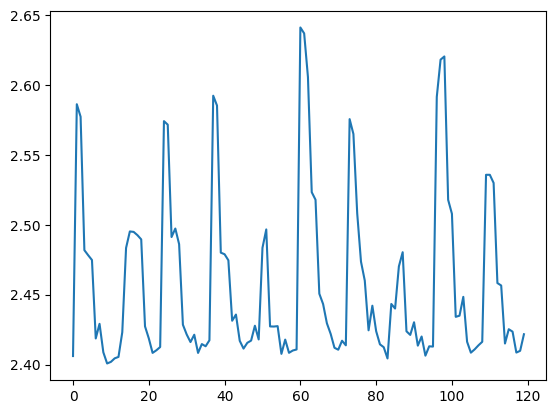

In [10]:
plt.plot(np.array(exec_times["attention_backward"]) / 1_000_000)

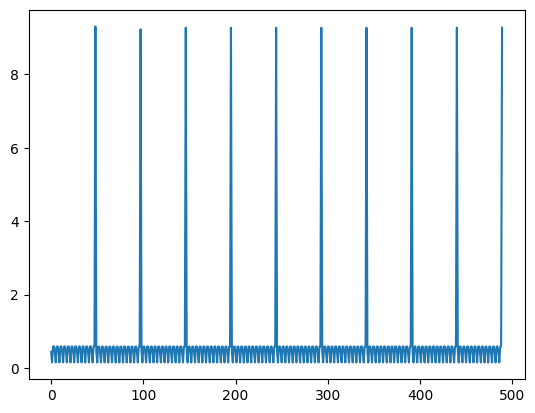

In [11]:
plt.plot(np.array(exec_times["mlp_forward"]) / 1_000_000)

### 1024 threads

In [12]:
rows = _(cur1024, "select ss.value, k.start, k.end from CUPTI_ACTIVITY_KIND_KERNEL as k join StringIds as ss where k.shortName = ss.id")

In [13]:
abstarts = np.array([row[1] for row in rows if "attention_backward" in row[0]])
(abstarts[1:] - abstarts[:-1]) / 1_000_000

array([ 17.533055,  17.760125,  17.555167,  17.569407,  17.565727,
        17.581182,  17.540832,  17.558238,  17.556063,  17.555967,
        17.539647, 193.793294,  17.906845,  17.998653,  17.679998,
        17.562335,  17.568382,  17.566431,  17.547743,  17.541119,
        17.550398,  17.564128,  17.541918, 190.481154,  18.724536,
        18.275003,  17.773373,  17.560191,  17.559327,  17.562622,
        17.54592 ,  17.55187 ,  17.548095,  17.566655,  17.534751,
       190.555649,  18.753176,  18.051868,  17.61635 ,  17.579967,
        17.572287,  17.551487,  17.534591,  17.53875 ,  17.552191,
        17.556575,  17.551743, 192.331031,  17.711198,  17.836125,
        17.602399,  17.561086,  17.569375,  17.581535,  17.544255,
        17.551071,  17.549278,  17.560927,  17.548253, 190.55906 ,
        18.407124,  18.357395,  17.821269,  17.596472,  17.560472,
        17.55996 ,  17.530616,  17.816854,  17.556056,  17.541943,
        17.549144, 190.430646,  19.102414,  18.25042 ,  17.741

In [14]:
exec_times_1024 = defaultdict(list)
for row in rows:
    exec_times_1024[row[0]].append(row[2] - row[1])

In [15]:
for name, times in exec_times_1024.items():
    print(f"{name} : \t {np.mean(times) / 1_000_000} ms")

embedding_forward : 	 0.3116655 ms
layernorm_forward : 	 0.177160724 ms
mlp_forward : 	 0.6180327530612245 ms
attention_forward : 	 6.006595675 ms
residual_forward : 	 0.008608733333333334 ms
gelu_forward : 	 0.0259303 ms
softmax_forward : 	 0.7898773 ms
cross_entropy_forward : 	 0.0031584 ms
cross_entropy_backward : 	 27.3539998 ms
mlp_backward_input : 	 0.796917018367347 ms
mlp_backward_weight : 	 0.775696730612245 ms
layernorm_backward : 	 0.46036662 ms
residual_backward : 	 0.012730149999999999 ms
gelu_backward : 	 0.04337604166666666 ms
attention_backward : 	 12.156599841666667 ms
embedding_backward : 	 0.5367553 ms
adamw_kernel : 	 10.121829400000001 ms


In [16]:
for name, times in exec_times_1024.items():
    print(f"{name} : \t {np.max(times) / 1_000_000} ms")

embedding_forward : 	 0.312574 ms
layernorm_forward : 	 0.182431 ms
mlp_forward : 	 9.343273 ms
attention_forward : 	 6.060828 ms
residual_forward : 	 0.009312 ms
gelu_forward : 	 0.026592 ms
softmax_forward : 	 0.791356 ms
cross_entropy_forward : 	 0.003296 ms
cross_entropy_backward : 	 27.424989 ms
mlp_backward_input : 	 10.984383 ms
mlp_backward_weight : 	 11.897978 ms
layernorm_backward : 	 0.499581 ms
residual_backward : 	 0.01328 ms
gelu_backward : 	 0.04448 ms
attention_backward : 	 13.130066 ms
embedding_backward : 	 0.541981 ms
adamw_kernel : 	 10.122532 ms


In [17]:
for name, times in exec_times_1024.items():
    print(f"{name} : \t {0.1 * np.sum(exec_times[name]) / 1_000_000}ms | {0.1 * np.sum(times) / 1_000_000} ms")

embedding_forward : 	 0.3119119ms | 0.3116655 ms
layernorm_forward : 	 4.4281224ms | 4.4290181 ms
mlp_forward : 	 30.2716847ms | 30.283604900000004 ms
attention_forward : 	 17.233962100000003ms | 72.07914810000001 ms
residual_forward : 	 0.1695898ms | 0.2066096 ms
gelu_forward : 	 0.2314965ms | 0.31116360000000004 ms
softmax_forward : 	 0.7900882ms | 0.7898773 ms
cross_entropy_forward : 	 0.0031136000000000002ms | 0.0031584 ms
cross_entropy_backward : 	 25.875274ms | 27.3539998 ms
mlp_backward_input : 	 39.399061200000006ms | 39.0489339 ms
mlp_backward_weight : 	 38.328390899999995ms | 38.00913980000001 ms
layernorm_backward : 	 11.667064700000001ms | 11.5091655 ms
residual_backward : 	 0.2698515ms | 0.30552360000000006 ms
gelu_backward : 	 0.465028ms | 0.5205125 ms
attention_backward : 	 29.496771ms | 145.8791981 ms
embedding_backward : 	 0.27600790000000003ms | 0.5367553 ms
adamw_kernel : 	 10.104635100000001ms | 10.121829400000001 ms


In [18]:
total = 0
total_1024 = 0
for name, times in exec_times_1024.items():
    total += 0.1 * np.sum(exec_times[name]) / 1_000_000
    total_1024 += 0.1 * np.sum(exec_times_1024[name]) / 1_000_000
    # print(f"{name} : \t {0.1 * np.sum(exec_times[name]) / 1_000_000}ms | {0.1 * np.sum(exec_times[name]) / 1_000_000} ms")

print(f"Per pass, total(128)={total}ms, total(1024)={total_1024}ms")

Per pass, total(128)=209.32205349999995ms, total(1024)=381.6993034ms


In [24]:
for name, times in exec_times_1024.items():
    print(f"{name} : \t {100 * (0.1 * np.sum(exec_times[name]) / 1_000_000) / total }% | {100 * (0.1 * np.sum(times) / 1_000_000) / total_1024} %")

embedding_forward : 	 0.14901052936593712% | 0.08165210080915226 %
layernorm_forward : 	 2.1154590861110587% | 1.1603422014523908 %
mlp_forward : 	 14.46177514210179% | 7.933890533791319 %
attention_forward : 	 8.233228086499738% | 18.88375154420049 %
residual_forward : 	 0.08101860131999901% | 0.05412889103009036 %
gelu_forward : 	 0.1105934592792441% | 0.08152060986967995 %
softmax_forward : 	 0.3774510075690616% | 0.20693705567815818 %
cross_entropy_forward : 	 0.0014874686866188235% | 0.0008274576274744126 %
cross_entropy_backward : 	 12.361465773600393% | 7.166374042693629 %
mlp_backward_input : 	 18.822221806647818% | 10.230286917521264 %
mlp_backward_weight : 	 18.310727541185717% | 9.957875076384015 %
layernorm_backward : 	 5.573738889390364% | 3.015244040919567 %
residual_backward : 	 0.12891689885891552% | 0.08004300696347565 %
gelu_backward : 	 0.22215910470226688% | 0.13636716005596985 %
attention_backward : 	 14.091573490129173% | 38.21835586299893 %
embedding_backward : 	

In [19]:
cur128.close()

In [20]:
B = 4
S = 64
NH = 12
T = S
C = 768
hs = C // NH
t = np.arange(B * S * NH)
h = np.arange(B * S * NH) % NH
b = np.arange(B * S * NH) // (NH * T)

t = ((t // NH) %  S)
(((b * T + (t * 0)) * C * 3 + h * hs + C * 2)[:256])

array([1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176,
       2240, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112,
       2176, 2240, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048,
       2112, 2176, 2240, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984,
       2048, 2112, 2176, 2240, 1536, 1600, 1664, 1728, 1792, 1856, 1920,
       1984, 2048, 2112, 2176, 2240, 1536, 1600, 1664, 1728, 1792, 1856,
       1920, 1984, 2048, 2112, 2176, 2240, 1536, 1600, 1664, 1728, 1792,
       1856, 1920, 1984, 2048, 2112, 2176, 2240, 1536, 1600, 1664, 1728,
       1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 1536, 1600, 1664,
       1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 1536, 1600,
       1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 1536,
       1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240,
       1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176,
       2240, 1536, 1600, 1664, 1728, 1792, 1856, 19

In [21]:
(((b * T + (t)) * C * 3 + h * hs + C * 2)[-256:])

array([541184, 541248, 541312, 541376, 542976, 543040, 543104, 543168,
       543232, 543296, 543360, 543424, 543488, 543552, 543616, 543680,
       545280, 545344, 545408, 545472, 545536, 545600, 545664, 545728,
       545792, 545856, 545920, 545984, 547584, 547648, 547712, 547776,
       547840, 547904, 547968, 548032, 548096, 548160, 548224, 548288,
       549888, 549952, 550016, 550080, 550144, 550208, 550272, 550336,
       550400, 550464, 550528, 550592, 552192, 552256, 552320, 552384,
       552448, 552512, 552576, 552640, 552704, 552768, 552832, 552896,
       554496, 554560, 554624, 554688, 554752, 554816, 554880, 554944,
       555008, 555072, 555136, 555200, 556800, 556864, 556928, 556992,
       557056, 557120, 557184, 557248, 557312, 557376, 557440, 557504,
       559104, 559168, 559232, 559296, 559360, 559424, 559488, 559552,
       559616, 559680, 559744, 559808, 561408, 561472, 561536, 561600,
       561664, 561728, 561792, 561856, 561920, 561984, 562048, 562112,
      